#Import&Installs

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 53 kB/s 
     |████████████████████████████████| 199 kB 77.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=64a136e8a5bcafd634a86cd98a338463b596e8f0b91e67a3dd213df3dffce94e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import json
import pyspark
from pyspark.sql import SparkSession
from itertools import combinations
from pyspark.sql.functions import concat, col, lit, udf, split
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.ml.classification import FMClassifier
from pyspark.ml.clustering import KMeans, LDA, GaussianMixture, PowerIterationClustering
from pyspark.ml.evaluation import ClusteringEvaluator,  MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, Imputer , StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier, LinearSVC, OneVsRest

In [ ]:
!gdown "1Mm6pePtdELX7aIqnp7J6SsphMnENMUX8"

Downloading...
From: https://drive.google.com/uc?id=1Mm6pePtdELX7aIqnp7J6SsphMnENMUX8
To: /content/Mini2Data.zip
100% 11.2M/11.2M [00:00<00:00, 82.9MB/s]


In [ ]:
!unzip 'Mini2Data.zip'

Archive:  Mini2Data.zip
  inflating: Data.csv                
  inflating: Id_To_ChampionName.txt  
  inflating: Id_To_ItemName.txt      
  inflating: ChampBuilds.txt         
  inflating: ChampClass.txt          


In [ ]:
#Read item Ids and Champion ids files to create a mapping
#Id maps to a name
Champs = open("Id_To_ChampionName.txt", "r")
ChampClass = open("ChampClass.txt", "r")
Items = open("Id_To_ItemName.txt", "r")

#Create Dicts
Id_to_ChampName={}
Id_to_ItemName={}
Id_to_ChampClass={}

#loop over lines
for line in Champs:
  data=line.strip().split('\t')
  Id_to_ChampName[data[0]]=data[1]

for line in Items:
  data=line.strip().split('\t')
  Id_to_ItemName[data[0]]=data[1]

for line in ChampClass:
  data=line.strip().split('\t')
  Id_to_ChampClass[data[0]]=data[1:]

print(Id_to_ChampName)
print(Id_to_ChampClass)
print(Id_to_ItemName)

{'ID': 'Name', '266': 'Aatrox', '103': 'Ahri', '84': 'Akali', '166': 'Akshan', '12': 'Alistar', '32': 'Amumu', '34': 'Anivia', '1': 'Annie', '523': 'Aphelios', '22': 'Ashe', '136': 'AurelionSol', '268': 'Azir', '432': 'Bard', '200': 'Belveth', '53': 'Blitzcrank', '63': 'Brand', '201': 'Braum', '51': 'Caitlyn', '164': 'Camille', '69': 'Cassiopeia', '31': 'Chogath', '42': 'Corki', '122': 'Darius', '131': 'Diana', '119': 'Draven', '36': 'DrMundo', '245': 'Ekko', '60': 'Elise', '28': 'Evelynn', '81': 'Ezreal', '9': 'Fiddlesticks', '114': 'Fiora', '105': 'Fizz', '3': 'Galio', '41': 'Gangplank', '86': 'Garen', '150': 'Gnar', '79': 'Gragas', '104': 'Graves', '887': 'Gwen', '120': 'Hecarim', '74': 'Heimerdinger', '420': 'Illaoi', '39': 'Irelia', '427': 'Ivern', '40': 'Janna', '59': 'JarvanIV', '24': 'Jax', '126': 'Jayce', '202': 'Jhin', '222': 'Jinx', '145': 'Kaisa', '429': 'Kalista', '43': 'Karma', '30': 'Karthus', '38': 'Kassadin', '55': 'Katarina', '10': 'Kayle', '141': 'Kayn', '85': 'Kenne

#Create Spark Session

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Mini-Project-2") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

#Load Data, Cleaning and Group By GameBatch

In [ ]:
Maindf = spark.read.load("Data.csv", format="csv", sep=",", inferSchema="true", header="true")

In [ ]:
Maindf.schema

StructType([StructField('_c0', IntegerType(), True), StructField('Champ1Team1', StringType(), True), StructField('Champ2Team1', StringType(), True), StructField('Champ3Team1', StringType(), True), StructField('Champ4Team1', StringType(), True), StructField('Champ5Team1', StringType(), True), StructField('BansTeam1', StringType(), True), StructField('MetaTeam1', StringType(), True), StructField('Champ1Team2', StringType(), True), StructField('Champ2Team2', StringType(), True), StructField('Champ3Team2', StringType(), True), StructField('Champ4Team2', StringType(), True), StructField('Champ5Team2', StringType(), True), StructField('BansTeam2', StringType(), True), StructField('MetaTeam2', StringType(), True), StructField('gameDuration (Mins)', DoubleType(), True), StructField('gameVersion', StringType(), True)])

In [ ]:
Maindf.show(5)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----------+-------------------+-----------+
|_c0|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|          BansTeam1|  MetaTeam1|         Champ1Team2|         Champ2Team2|         Champ3Team2|         Champ4Team2|         Champ5Team2|          BansTeam2| MetaTeam2|gameDuration (Mins)|gameVersion|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----------+-------------------+-----------+
|  0|114,6632,3074,316...|120,3074,3042,315...|90,3020,3157,3916...

##Cleaning

We noticed later on in the project that some of the collected game durations
are written in Milli seconds

In [ ]:
Maindf = Maindf.select(["Champ1Team1","Champ2Team1","Champ3Team1","Champ4Team1","Champ5Team1","BansTeam1","MetaTeam1",
"Champ1Team2","Champ2Team2","Champ3Team2","Champ4Team2","Champ5Team2","BansTeam2","MetaTeam2",
'gameDuration (Mins)','gameVersion'])

In [ ]:
Maindf = Maindf.drop_duplicates()

In [ ]:
Maindf.select(['gameDuration (Mins)']).sort(['gameDuration (Mins)'],ascending=False).show(5)

+-------------------+
|gameDuration (Mins)|
+-------------------+
|            53403.2|
|           50278.43|
|           49932.07|
|           47154.52|
|           43805.78|
+-------------------+
only showing top 5 rows



In [ ]:
def TurntoMs(GameDur):
  #lets test on 1000 as the limit
  GameDur=float(GameDur)
  if GameDur > 1000:
    return GameDur/1000
  else:
    return GameDur
MyFunc = udf(lambda x:TurntoMs(x),DoubleType())

In [ ]:
Maindf=Maindf.withColumn("gameDuration (Mins)", MyFunc(Maindf['gameDuration (Mins)']))

In [ ]:
Maindf.select(['gameDuration (Mins)']).sort(['gameDuration (Mins)'],ascending=False).show(5)

+-------------------+
|gameDuration (Mins)|
+-------------------+
|              60.37|
|              59.02|
|              58.98|
|              57.37|
|              56.63|
+-------------------+
only showing top 5 rows



In [ ]:
Maindf.select(['gameDuration (Mins)']).sort(['gameDuration (Mins)']).show(5)

+-------------------+
|gameDuration (Mins)|
+-------------------+
|               1.68|
|               1.68|
|               1.68|
|               1.68|
|               1.68|
+-------------------+
only showing top 5 rows



## Group Data By Game Batch
Here we will partition the data by game batchs
but we will work with all the data.

**This is just to prove that we can do the Bonus!**

In [ ]:
def TurnStringTobatch(string):
  batch=''.join(string[:4].split(","))
  if batch.endswith('.'):
    batch=batch[:-1]
  return float(batch)
MyFunc = udf(lambda x:TurnStringTobatch(x),DoubleType())

In [ ]:
df=Maindf.withColumn("gameBatch", MyFunc(Maindf.gameVersion))

df.groupBy('gameBatch').agg({"gameBatch": "count"}).collect()

[Row(gameBatch=11.0, count(gameBatch)=745),
 Row(gameBatch=12.0, count(gameBatch)=94977)]

In [ ]:
Batch1=df.filter(df.gameBatch == 11.0)
Batch1.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------+-------------------+-----------+---------+
|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|        BansTeam1|  MetaTeam1|         Champ1Team2|         Champ2Team2|         Champ3Team2|         Champ4Team2|         Champ5Team2|         BansTeam2| MetaTeam2|gameDuration (Mins)|gameVersion|gameBatch|
+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------+-------------------+-----------+---------+
|82,105,446,333,15...|131,315,231,573,0...|777,300,666,733

In [ ]:
Batch2=df.filter(df.gameBatch == 12.0)
Batch2.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------+-------------------+-----------+---------+
|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|          BansTeam1|  MetaTeam1|         Champ1Team2|         Champ2Team2|         Champ3Team2|         Champ4Team2|         Champ5Team2|         BansTeam2| MetaTeam2|gameDuration (Mins)|gameVersion|gameBatch|
+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------+-------------------+-----------+---------+
|48,3074,6632,3047...|82,666,531,164,63...|246,669,6

#Requriments

In [ ]:
!rm -r    '/content/AnalysisResults'
!mkdir    '/content/AnalysisResults'

rm: cannot remove '/content/AnalysisResults': No such file or directory


In [ ]:
savePath='/content/AnalysisResults/'
#total number of rows
df = Maindf
df_count = df.count()
df_count

95722

##Champion win, lose, pick, and ban rates

###Champion Win Rate

In [ ]:
#Since we made the data set we set the left team to be the one that won
ChampionsWon=df.select(["Champ1Team1","Champ2Team1","Champ3Team1","Champ4Team1","Champ5Team1"])
ChampionsWon.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|48,3074,6632,3047...|82,666,531,164,63...|246,669,631,563,1...|67,3124,6672,3006...|63,385,366,533,02...|
|82,105,446,333,15...|131,315,231,573,0...|777,300,666,733,0...|236,667,120,313,5...|111,3190,0,3860,2...|
|67,105,530,061,08...|234,6632,2031,304...|84,242,020,313,15...|119,350,831,393,0...|16,105,238,531,05...|
|23,667,130,316,67...|254,6632,3047,0,3...|90,302,066,533,91...|202,304,766,766,6...|235,300,938,646,6...|
|266,669,430,471,0...|120,315,866,653,0...|91,307,466,946,69...|145,667,266,763,0...|161,3853,4628,300...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
WinRates = ChampionsWon.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[0],1)) \
          .reduceByKey(lambda c1,c2:c1+c2) \
          .map(lambda champ:(champ[0],round((champ[1]/(df_count))*100,2)))\
          .sortBy(lambda champ: champ[1], ascending=False)\
          .map(lambda champ:(Id_to_ChampName.get(champ[0]),champ[1])) \
          .collect()

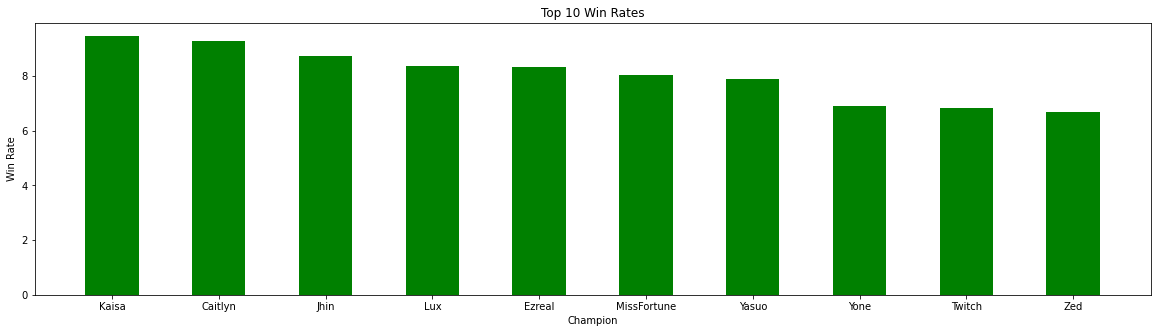

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(WinRates)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Win Rate')
ax.set_xlabel('Champion')
plt.title("Top 10 Win Rates")
plt.show()
plt.savefig(savePath+'Top 10 Win Rates.png')

###Champion Lose Rate

In [ ]:
#Since we made the data set we set the left team to be the one that won
ChampionsLost=df.select(["Champ1Team2","Champ2Team2","Champ3Team2","Champ4Team2","Champ5Team2"])

In [ ]:
LoseRates= ChampionsLost.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[0],1)) \
          .reduceByKey(lambda c1,c2:c1+c2) \
          .map(lambda champ:(champ[0],round((champ[1]/(df_count))*100,2)))\
          .sortBy(lambda champ: champ[1], ascending=False)\
          .map(lambda champ:(Id_to_ChampName.get(champ[0]),champ[1])) \
          .collect()

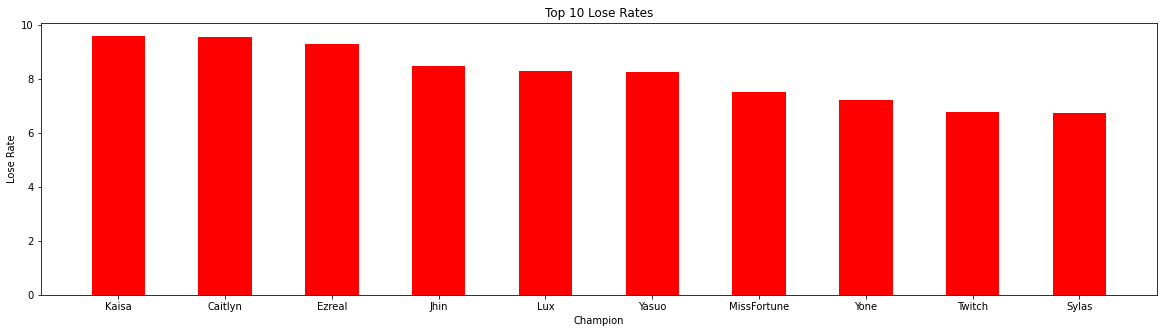

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(LoseRates)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['red'],width = 0.5)
ax.set_ylabel('Lose Rate')
ax.set_xlabel('Champion')
plt.title("Top 10 Lose Rates")
plt.show()
plt.savefig(savePath+'Top 10 Lose Rates.png')

### Champion Pick Rate

In [ ]:
#Since we take all picks in all the matches
Champions=df.select(["Champ1Team1","Champ2Team1","Champ3Team1","Champ4Team1","Champ5Team1",
"Champ1Team2","Champ2Team2","Champ3Team2","Champ4Team2","Champ5Team2"])

In [ ]:
PickRates= Champions.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[0],1)) \
          .reduceByKey(lambda c1,c2:c1+c2) \
          .map(lambda champ:(champ[0],round((champ[1]/(df_count))*100,2)))\
          .sortBy(lambda champ: champ[1], ascending=False)\
          .map(lambda champ:(Id_to_ChampName.get(champ[0]),champ[1])) \
          .collect()

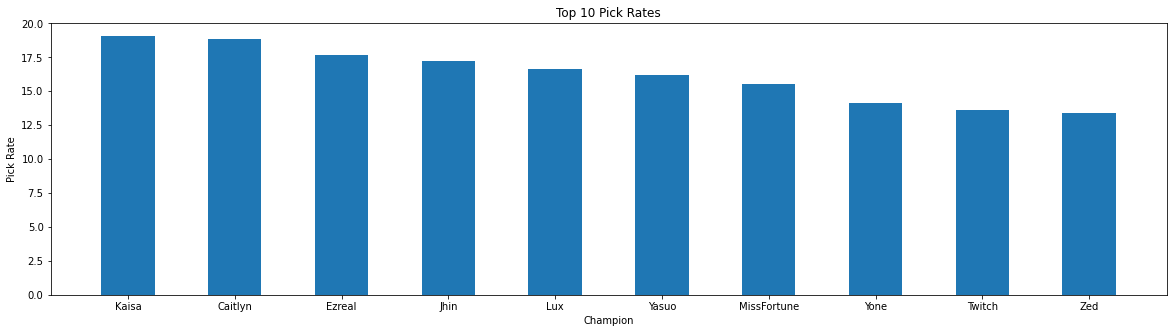

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(PickRates)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,width = 0.5)
ax.set_ylabel('Pick Rate')
ax.set_xlabel('Champion')
plt.title("Top 10 Pick Rates")
plt.show()
plt.savefig(savePath+'Top 10 Pick Rates.png')

###Champion Ban Rate

In [ ]:
#Since we take all bans in all the matches
ChampionBans=df.select(['BansTeam1','BansTeam2'])
ChampionBans.show(5)

+-------------------+------------------+
|          BansTeam1|         BansTeam2|
+-------------------+------------------+
|  238,145,54,897,99|  9,17,200,895,120|
|   555,350,122,8,48| 166,711,53,350,-1|
|  57,350,77,360,120|266,350,105,245,-1|
|120,234,221,238,266|  98,221,777,25,45|
|   25,33,350,39,112|   114,28,166,84,9|
+-------------------+------------------+
only showing top 5 rows



In [ ]:
BanRates= ChampionBans.rdd.flatMap(lambda x:x) \
          .map(lambda champ:(champ.split(','))) \
          .flatMap(lambda champ:champ) \
          .map(lambda champ:(champ,1)) \
          .reduceByKey(lambda c1,c2:c1+c2) \
          .map(lambda champ:(champ[0],round((champ[1]/(df_count))*100,2)))\
          .filter(lambda champ: int(champ[0])>0) \
          .sortBy(lambda champ: champ[1], ascending=False)\
          .map(lambda champ:(Id_to_ChampName.get(champ[0]),champ[1])) \
          .collect()

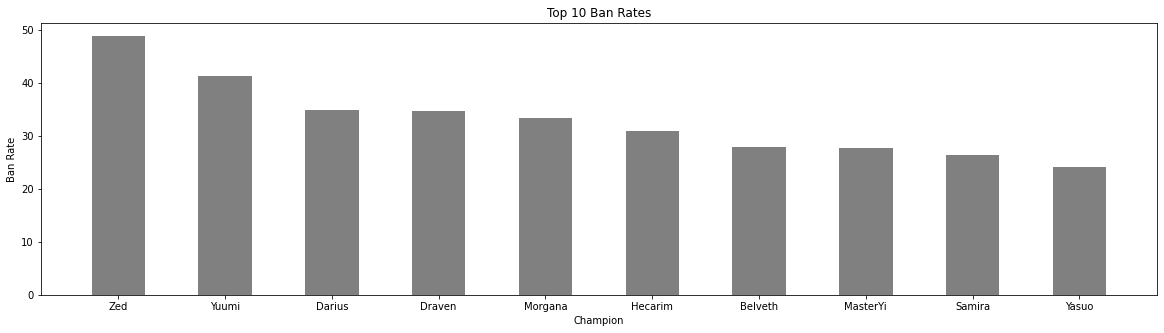

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(BanRates)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values, color=['grey'] ,width = 0.5)
ax.set_ylabel('Ban Rate')
ax.set_xlabel('Champion')
plt.title("Top 10 Ban Rates")
plt.show()
plt.savefig(savePath+'Top 10 Ban Rates.png')

##Champion Synergies or duos

We can make pairs of each champion with the other champions in the winning team. Then count those pairs.

Good Synergies are without a doubt more in the winning teams
but also we need to account for losing team.

so our forumla for Synergies are pairs that won but with a higher score plus pairs that lost

In [ ]:
ChampionsWon=df.select(["Champ1Team1","Champ2Team1","Champ3Team1","Champ4Team1","Champ5Team1"])
ChampionsWon=ChampionsWon.withColumn('champs',
                    concat(col('Champ1Team1'),lit('_'),
                           col('Champ2Team1'),lit('_'),
                           col('Champ3Team1'),lit('_'),
                           col('Champ4Team1'),lit('_'),
                           col('Champ5Team1')))
ChampionsWon=ChampionsWon.select(['champs'])

In [ ]:
ChampionsLost=df.select(["Champ1Team2","Champ2Team2","Champ3Team2","Champ4Team2","Champ5Team2"])
ChampionsLost=ChampionsLost.withColumn('champs',
                    concat(col('Champ1Team2'),lit('_'),
                           col('Champ2Team2'),lit('_'),
                           col('Champ3Team2'),lit('_'),
                           col('Champ4Team2'),lit('_'),
                           col('Champ5Team2')))
ChampionsLost=ChampionsLost.select(['champs'])

In [ ]:
def GetChampCombinations(string):
    champs = string.split('_')
    #get the id of all the champions in the team
    ChampIds = [int(champ.split(',')[0]) for champ in champs]
    #replace the id with the name
    ChampList = [Id_to_ChampName.get(str(id)) for id in ChampIds]
    #sort the names to avoid tuples that contain the same two champions but in different order
    ChampList.sort()
    #return the combinations of the given team
    return list(combinations(ChampList, 2))

In [ ]:
SynergiesWon = ChampionsWon.rdd.flatMap(lambda x:x)\
          .map(lambda champList:GetChampCombinations(champList)) \
          .flatMap(lambda pair:pair) \
          .map(lambda pair:(pair,2)) \
          .reduceByKey(lambda pair1,pair2:pair1+pair2)

SynergiesLost = ChampionsLost.rdd.flatMap(lambda x:x)\
          .map(lambda champList:GetChampCombinations(champList)) \
          .flatMap(lambda pair:pair) \
          .map(lambda pair:(pair,1)) \
          .reduceByKey(lambda pair1,pair2:pair1+pair2)

Synergies = SynergiesLost.union(SynergiesWon)\
        .reduceByKey(lambda pair1,pair2:pair1+pair2) \
        .sortBy(lambda Syn:Syn[1],ascending=False) \
        .collect()

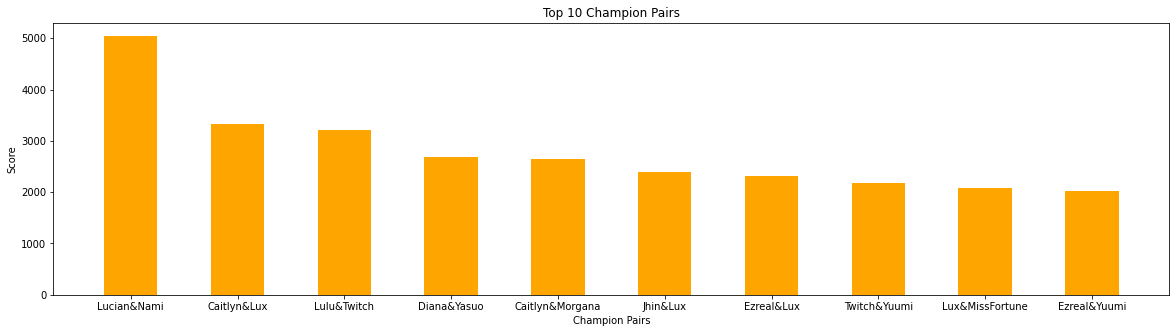

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(Synergies)
pairs = list(data.keys())[:10]
keys = ['&'.join(pair) for pair in pairs]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['orange'],width = 0.5)
ax.set_ylabel('Score')
ax.set_xlabel('Champion Pairs')
plt.title("Top 10 Champion Pairs")
plt.show()
plt.savefig(savePath+'Top 10 Champion Pairs.png')

##Item Win, Pick And Lose Rates

Some items appear alot in the game multple times accros the same team
for example boots this item nearly every champion in match buys.

In [ ]:
# item ids of redundant items
RedundantItems=['1001','3047','3111','3117','3158','3364','2003','2055','3006','3009','3020','2031']

###Item Win Rate

In [ ]:
#Since we made the data set we set the left team to be the one that won
ChampionsWon=df.select(["Champ1Team1","Champ2Team1","Champ3Team1","Champ4Team1","Champ5Team1"])

In [ ]:
ItemWinRates= ChampionsWon.rdd.flatMap(lambda x:x)\
          .map(lambda Item:(Item.split(','))) \
          .flatMap(lambda Item:Item[1:]) \
          .map(lambda Item:(Item,1)) \
          .reduceByKey(lambda Item1,Item2:Item1+Item2) \
          .map(lambda Item:(Item[0],round((Item[1]/(df_count))*100,2))) \
          .filter(lambda Item: int(Item[0])>0 and Item[0] not in RedundantItems) \
          .map(lambda Item:(Id_to_ItemName.get(Item[0]),Item[1])) \
          .filter(lambda Item: Item[0] != None) \
          .sortBy(lambda Item: Item[1], ascending=False) \
          .collect()

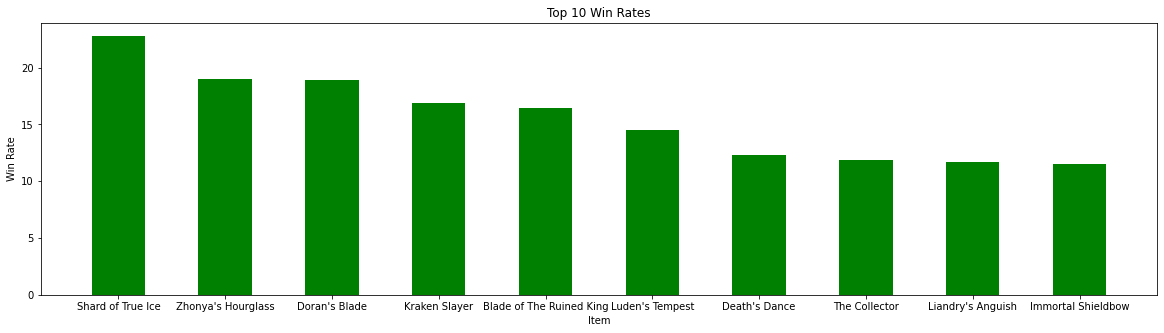

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ItemWinRates)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Win Rate')
ax.set_xlabel('Item')
plt.title("Top 10 Win Rates")
plt.show()
plt.savefig(savePath+'Top 10 Win Rates (Items).png')

###Item Pick Rate

In [ ]:
#Sellect all items
Champions=df.select(["Champ1Team1","Champ2Team1","Champ3Team1","Champ4Team1","Champ5Team1",
"Champ1Team2","Champ2Team2","Champ3Team2","Champ4Team2","Champ5Team2"])

In [ ]:
ItemPickRates= Champions.rdd.flatMap(lambda x:x)\
          .map(lambda Item:(Item.split(','))) \
          .flatMap(lambda Item:Item[1:]) \
          .map(lambda Item:(Item,1)) \
          .reduceByKey(lambda Item1,Item2:Item1+Item2) \
          .map(lambda Item:(Item[0],round((Item[1]/(df_count*2))*100,2))) \
          .filter(lambda Item: int(Item[0])>0 and Item[0] not in RedundantItems) \
          .map(lambda Item:(Id_to_ItemName.get(Item[0]),Item[1])) \
          .filter(lambda Item: Item[0] != None) \
          .sortBy(lambda Item: Item[1], ascending=False) \
          .collect()

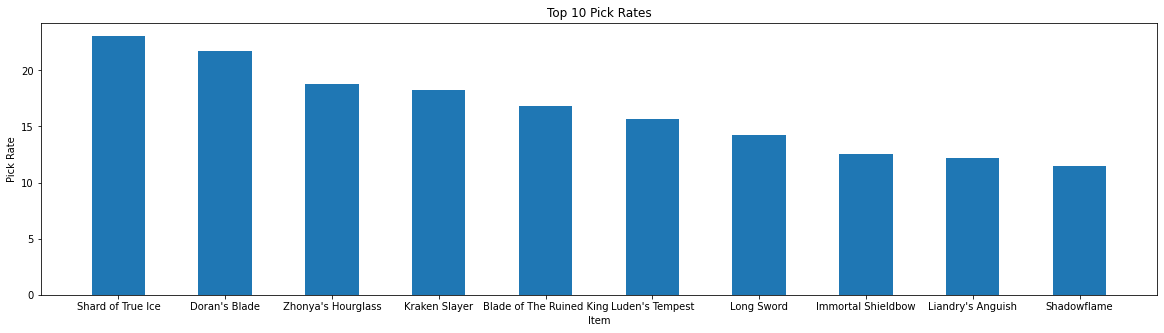

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ItemPickRates)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,width = 0.5)
ax.set_ylabel('Pick Rate')
ax.set_xlabel('Item')
plt.title("Top 10 Pick Rates")
plt.show()
plt.savefig(savePath+'Top 10 Pick Rates (Items).png')

###Item Lose Rate

In [ ]:
ChampionsLost=df.select(["Champ1Team2","Champ2Team2","Champ3Team2","Champ4Team2","Champ5Team2"])

In [ ]:
ItemLoseRates= ChampionsLost.rdd.flatMap(lambda x:x)\
          .map(lambda Item:(Item.split(','))) \
          .flatMap(lambda Item:Item[1:]) \
          .map(lambda Item:(Item,1)) \
          .reduceByKey(lambda Item1,Item2:Item1+Item2) \
          .map(lambda Item:(Item[0],round((Item[1]/(df_count))*100,2))) \
          .filter(lambda Item: int(Item[0])>0 and Item[0] not in RedundantItems) \
          .map(lambda Item:(Id_to_ItemName.get(Item[0]),Item[1])) \
          .filter(lambda Item: Item[0] != None) \
          .sortBy(lambda Item: Item[1], ascending=False) \
          .collect()

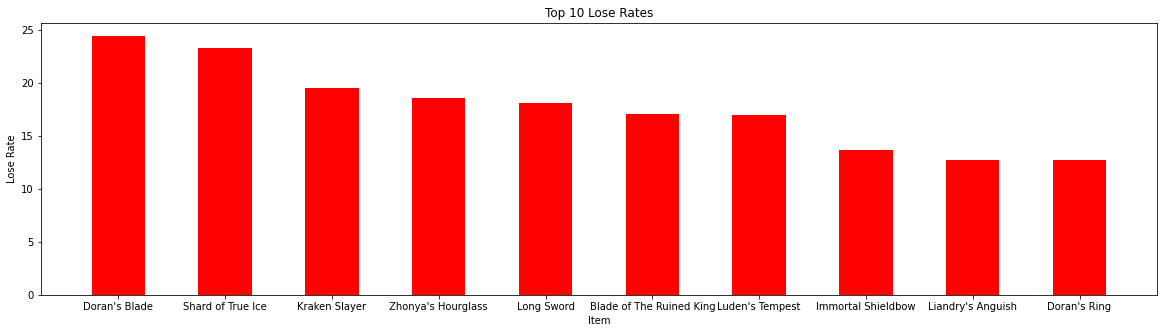

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ItemLoseRates)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['red'],width = 0.5)
ax.set_ylabel('Lose Rate')
ax.set_xlabel('Item')
plt.title("Top 10 Lose Rates")
plt.show()
plt.savefig(savePath+'Top 10 Lose Rates (Items).png')

##Item Synergies

Since Item Synergies are present in builds in generel
we can go through both teams

In [ ]:
OurChosenItems=['3156','3157','3074']

Champions=df.select(["Champ1Team1","Champ2Team1","Champ3Team1","Champ4Team1","Champ5Team1",
                     "Champ1Team2","Champ2Team2","Champ3Team2","Champ4Team2","Champ5Team2"])

###Item With Champion

In [ ]:
ItemSynergies = Champions.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(','))) \
          .flatMap(lambda champ:[((champ[0],item),1)for item in champ[1:] if int(item)>0 and item not in RedundantItems and item in OurChosenItems]) \
          .reduceByKey(lambda champItem1,champItem2:champItem1+champItem2) \
          .map(lambda Item:((Id_to_ChampName.get(Item[0][0]),Id_to_ItemName.get(Item[0][1])),Item[1])) \
          .filter(lambda Item: Item[0][0] != None) \
          .sortBy(lambda Item: Item[1], ascending=False) \
          .collect()

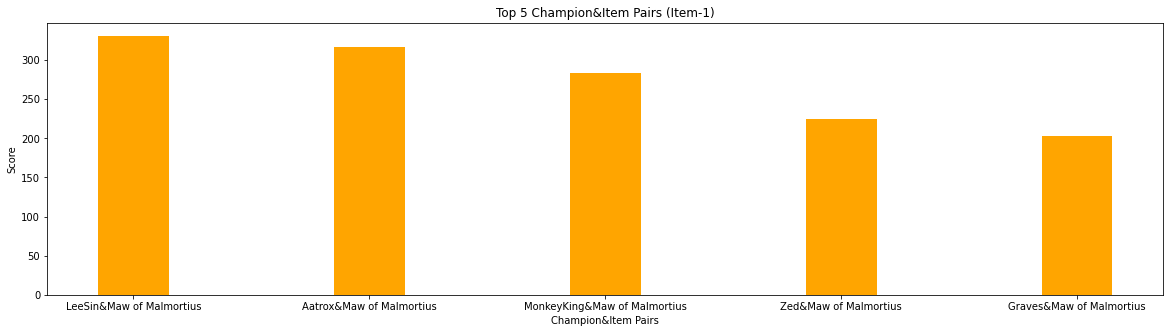

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ItemSynergies)
pairs = list(data.keys())
keys = [pair for pair in pairs if pair[1]==Id_to_ItemName[OurChosenItems[0]]]
values = [data[key] for key in keys][:5]
keys = ['&'.join(pair) for pair in keys][:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['orange'],width = 0.3)
ax.set_ylabel('Score')
ax.set_xlabel('Champion&Item Pairs')
plt.title("Top 5 Champion&Item Pairs (Item-1)")
plt.show()
plt.savefig(savePath+'Top 5 Champion&Item Pairs (Item-1).png')

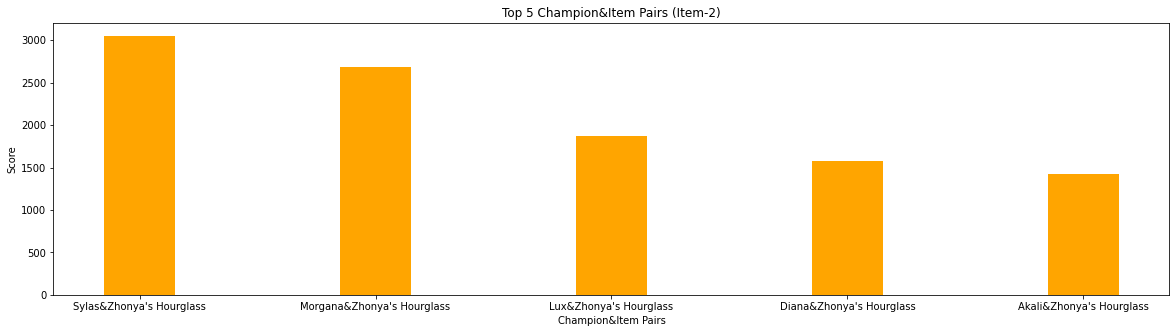

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ItemSynergies)
pairs = list(data.keys())
keys = [pair for pair in pairs if pair[1]==Id_to_ItemName[OurChosenItems[1]]]
values = [data[key] for key in keys][:5]
keys = ['&'.join(pair) for pair in keys][:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['orange'],width = 0.3)
ax.set_ylabel('Score')
ax.set_xlabel('Champion&Item Pairs')
plt.title("Top 5 Champion&Item Pairs (Item-2)")
plt.show()
plt.savefig(savePath+'Top 5 Champion&Item Pairs (Item-2).png')

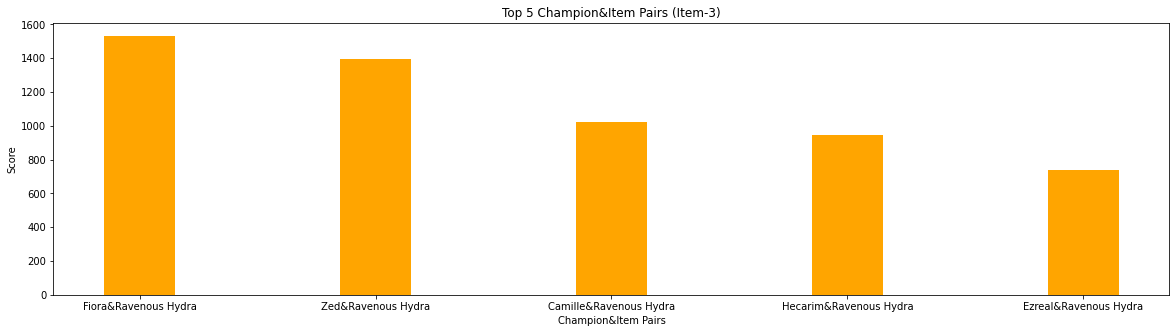

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ItemSynergies)
pairs = list(data.keys())
keys = [pair for pair in pairs if pair[1]==Id_to_ItemName[OurChosenItems[2]]]
values = [data[key] for key in keys][:5]
keys = ['&'.join(pair) for pair in keys][:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['orange'],width = 0.3)
ax.set_ylabel('Score')
ax.set_xlabel('Champion&Item Pairs')
plt.title("Top 5 Champion&Item Pairs (Item-3)")
plt.show()
plt.savefig(savePath+'Top 5 Champion&Item Pairs (Item-3).png')

###Item With Class

In [ ]:
def TurnChampItemToClassItem(ChampItem):
  ChampClasses=Id_to_ChampClass.get(ChampItem[0])
  if len(ChampClasses)==2:
    return  [((Class,ChampItem[1]),1) for Class in ChampClasses]
  else:
    return [((ChampClasses[0],ChampItem[1]),1)]

In [ ]:
ItemClassSynergies = Champions.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(','))) \
          .flatMap(lambda champ:[(champ[0],item) for item in champ[1:] if int(item)>0 and item not in RedundantItems and item in OurChosenItems]) \
          .flatMap(lambda ChampItem:TurnChampItemToClassItem(ChampItem)) \
          .reduceByKey(lambda classItem1,classItem2:classItem1+classItem2) \
          .map(lambda Item:((Item[0][0],Id_to_ItemName.get(Item[0][1])),Item[1])) \
          .filter(lambda Item: Item[0][1] != None) \
          .sortBy(lambda Item: Item[1], ascending=False) \
          .collect()

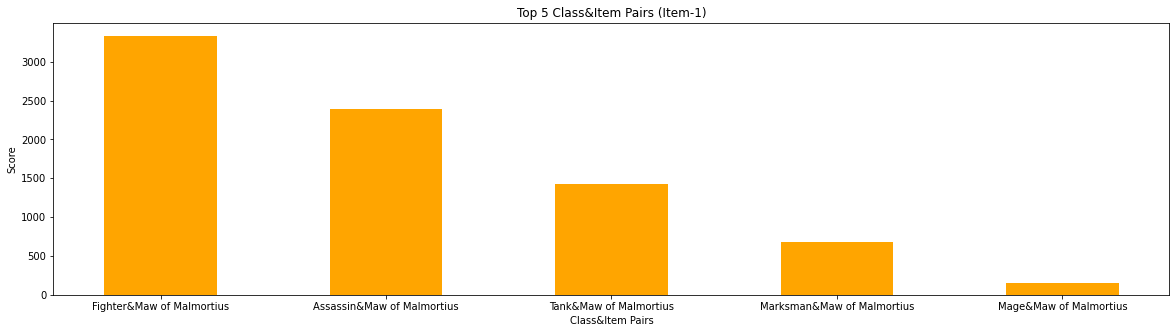

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ItemClassSynergies)
pairs = list(data.keys())
keys = [pair for pair in pairs if pair[1]==Id_to_ItemName[OurChosenItems[0]]]
values = [data[key] for key in keys][:5]
keys = ['&'.join(pair) for pair in keys][:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['orange'],width = 0.5)
ax.set_ylabel('Score')
ax.set_xlabel('Class&Item Pairs')
plt.title("Top 5 Class&Item Pairs (Item-1)")
plt.show()
plt.savefig(savePath+'Top 5 Class&Item Pairs(Item-1).png')

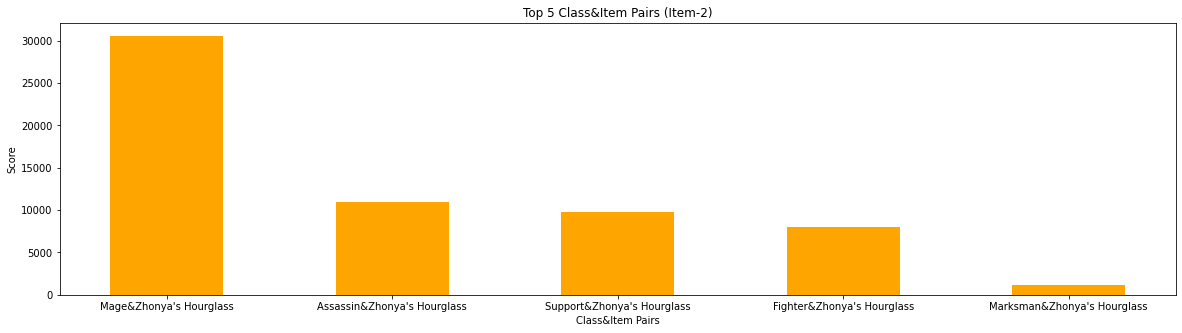

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ItemClassSynergies)
pairs = list(data.keys())
keys = [pair for pair in pairs if pair[1]==Id_to_ItemName[OurChosenItems[1]]]
values = [data[key] for key in keys][:5]
keys = ['&'.join(pair) for pair in keys][:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['orange'],width = 0.5)
ax.set_ylabel('Score')
ax.set_xlabel('Class&Item Pairs')
plt.title("Top 5 Class&Item Pairs (Item-2)")
plt.show()
plt.savefig(savePath+'Top 5 Class&Item Pairs(Item-2).png')

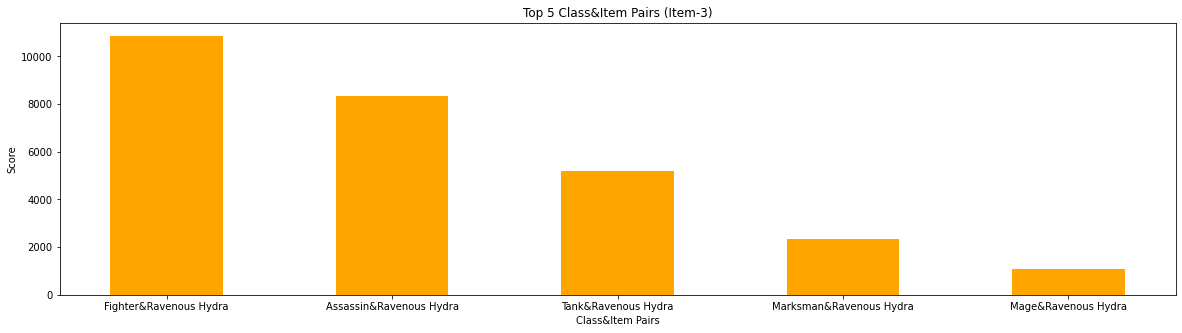

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ItemClassSynergies)
pairs = list(data.keys())
keys = [pair for pair in pairs if pair[1]==Id_to_ItemName[OurChosenItems[2]]]
values = [data[key] for key in keys][:5]
keys = ['&'.join(pair) for pair in keys][:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['orange'],width = 0.5)
ax.set_ylabel('Score')
ax.set_xlabel('Class&Item Pairs')
plt.title("Top 5 Class&Item Pairs (Item-3)")
plt.show()
plt.savefig(savePath+'Top 5 Class&Item Pairs(Item-3).png')

##Item Suggestion
We will try to suggest Builds
The judge here is that good items appear more.

In [ ]:
Champions=df.select(["Champ1Team1","Champ2Team1","Champ3Team1","Champ4Team1","Champ5Team1",
                     "Champ1Team2","Champ2Team2","Champ3Team2","Champ4Team2","Champ5Team2"])
Champions.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|         Champ1Team2|         Champ2Team2|         Champ3Team2|         Champ4Team2|         Champ5Team2|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|48,3074,6632,3047...|82,666,531,164,63...|246,669,631,563,1...|67,3124,6672,3006...|63,385,366,533,02...|41,2033,3508,3047...|56,6696,3156,6691...|90,665,331,164,63...|81,3074,3158,3078...|29,311,538,533,00...|
|82,105,446,333,15...|131,315,231,573,0...|777,300,666,733,0...|236,667,120,313,5...|111,3190,0,3860,2...|24,105,531,583,07...|79,3152,3165,3020...|157,

In [ ]:
def GetChampBuild(champ):
  champData=champ.split(',')
  champName=Id_to_ChampName[champData[0]]
  champItems=[(champName, Id_to_ItemName.get(id)) for id in champData[1:] if Id_to_ItemName.get(id) != None]
  return champItems

In [ ]:
Builds = Champions.rdd.flatMap(lambda x:x)\
          .flatMap(lambda champ:GetChampBuild(champ)) \
          .filter(lambda Item: Item[1] != None) \
          .map(lambda champItem:(champItem,1)) \
          .reduceByKey(lambda champItem1,champItem2:champItem1+champItem2) \
          .map(lambda champItem:(champItem[0][0],(champItem[0][1],champItem[1]))) \
          .reduceByKey(lambda champItem1,champItem2:champItem1+champItem2) \
          .collect()
# now we have dict for all items a champion buys
# lets start recommending

In [ ]:
# lets first create a txt file that will contain the champ items
# to recommend realtime with a python script given the champ name
BuildsDict = dict(Builds)
champNames = list(BuildsDict.keys())
SortedDictBuilds={}
for champ in champNames:
  temp=[]
  for i in range(0,len(BuildsDict[champ]),2):
    temp.append((BuildsDict[champ][i+1],BuildsDict[champ][i]))
  temp.sort(reverse=True)
  SortedDictBuilds[champ]=temp

with open(savePath+'ChampBuilds.txt','w') as f:
  for champ in champNames:
    f.write('{}\t{}\n'.format(champ,",".join(item[1] for item in SortedDictBuilds[champ])))
f.close()

In [ ]:
OurChosenChamps=['Zed','Zac','Brand','Jinx','Aatrox']

In [ ]:
for champ in OurChosenChamps:
  print(champ)
  for i in range(0,6):
    print('\t',SortedDictBuilds[champ][i][1])
  print("*"*40)

Zed
	 Ionian Boots of Lucidity
	 Eclipse
	 Youmuu's Ghostblade
	 Long Sword
	 Serylda's Grudge
	 Ravenous Hydra
****************************************
Zac
	 Sunfire Aegis
	 Ionian Boots of Lucidity
	 Demonic Embrace
	 Thornmail
	 Plated Steelcaps
	 Refillable Potion
****************************************
Brand
	 Liandry's Anguish
	 Sorcerer's Shoes
	 Shard of True Ice
	 Demonic Embrace
	 Rylai's Crystal Scepter
	 Zhonya's Hourglass
****************************************
Jinx
	 Berserker's Greaves
	 Kraken Slayer
	 Doran's Blade
	 Phantom Dancer
	 Infinity Edge
	 Rapid Firecannon
****************************************
Aatrox
	 Plated Steelcaps
	 Eclipse
	 Black Cleaver
	 Death's Dance
	 Doran's Shield
	 Mercury's Treads
****************************************


#Proposal

In [ ]:
MetaWon = df.select(["MetaTeam1"])

##Win Rate&Baron Kills

In [ ]:
BaronWinRates = MetaWon.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[1],1)) \
          .reduceByKey(lambda g1,g2:g1+g2) \
          .map(lambda game:(game[0],round((game[1]/(df_count))*100,2)))\
          .sortBy(lambda game: game[0])\
          .collect()
BaronWinRates

[('0', 35.43),
 ('1', 51.05),
 ('2', 12.59),
 ('3', 0.89),
 ('4', 0.04),
 ('5', 0.0)]

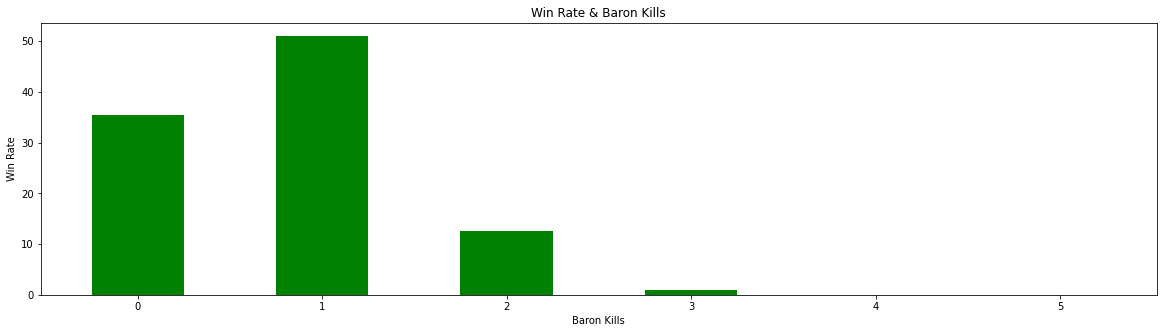

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(BaronWinRates)
keys = list(data.keys())
values = list(data.values())
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Win Rate')
ax.set_xlabel('Baron Kills')
plt.title("Win Rate & Baron Kills")
plt.show()
plt.savefig(savePath+'Win Rate & Baron Kills.png')

##Win Rate&Dragon Kills

In [ ]:
DragonWinRates = MetaWon.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[2],1)) \
          .reduceByKey(lambda g1,g2:g1+g2) \
          .map(lambda game:(game[0],round((game[1]/(df_count))*100,2)))\
          .sortBy(lambda game: game[0])\
          .collect()
DragonWinRates

[('0', 3.46),
 ('1', 10.56),
 ('2', 27.19),
 ('3', 32.41),
 ('4', 22.49),
 ('5', 3.71),
 ('6', 0.17),
 ('7', 0.01)]

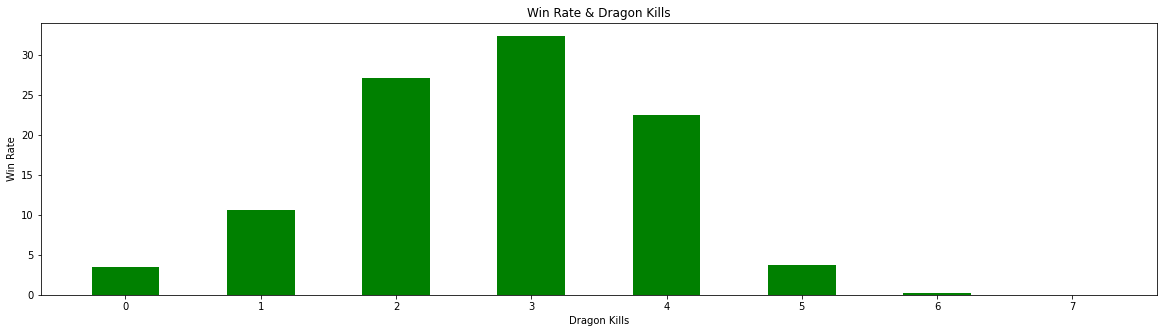

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(DragonWinRates)
keys = list(data.keys())
values = list(data.values())
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Win Rate')
ax.set_xlabel('Dragon Kills')
plt.title("Win Rate & Dragon Kills")
plt.show()
plt.savefig(savePath+'Win Rate & Dragon Kills.png')

##Win Rate&Rift Kills

In [ ]:
RiftWinRates = MetaWon.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[3],1)) \
          .reduceByKey(lambda g1,g2:g1+g2) \
          .map(lambda game:(game[0],round((game[1]/(df_count))*100,2)))\
          .sortBy(lambda game: game[0])\
          .collect()
RiftWinRates

[('0', 30.75), ('1', 43.32), ('2', 25.93)]

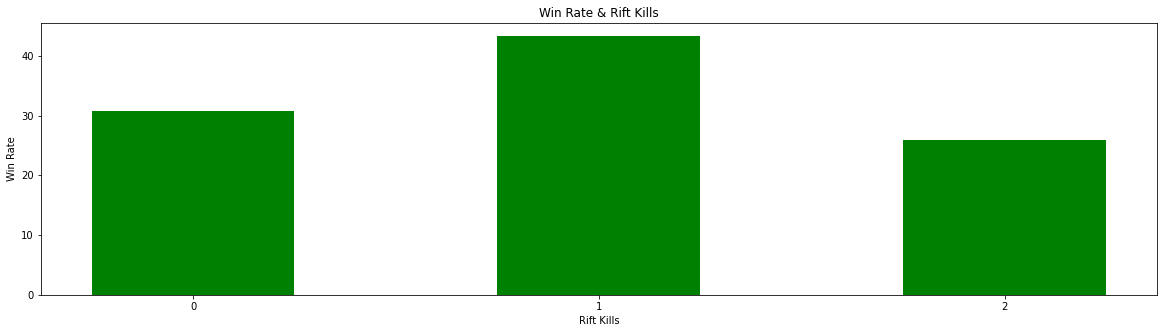

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(RiftWinRates)
keys = list(data.keys())
values = list(data.values())
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Win Rate')
ax.set_xlabel('Rift Kills')
plt.title("Win Rate & Rift Kills")
plt.show()
plt.savefig(savePath+'Win Rate & Rift Kills.png')

##Win Rate&Baron&Dragon Kills

In [ ]:
BaronDragonWinRates = MetaWon.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[1]+"&"+champ.split(',')[2],1)) \
          .reduceByKey(lambda g1,g2:g1+g2) \
          .map(lambda game:(game[0],round((game[1]/(df_count))*100,2)))\
          .sortBy(lambda game: game[1],ascending=False)\
          .collect()

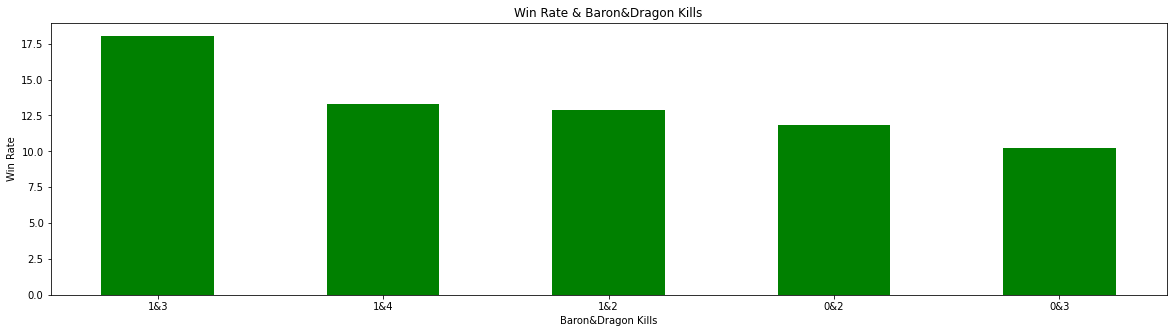

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(BaronDragonWinRates)
keys = list(data.keys())[:5]
values = list(data.values())[:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Win Rate')
ax.set_xlabel('Baron&Dragon Kills')
plt.title("Win Rate & Baron&Dragon Kills")
plt.show()
plt.savefig(savePath+'Win Rate Baron&Dragon Kills.png')

##Team Champion Kills&Win Rate

In [ ]:
ChampionWinRates = MetaWon.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[0],1)) \
          .reduceByKey(lambda g1,g2:g1+g2) \
          .map(lambda game:(game[0],round((game[1]/(df_count))*100,2)))\
          .sortBy(lambda game: game[1],ascending=False)\
          .collect()

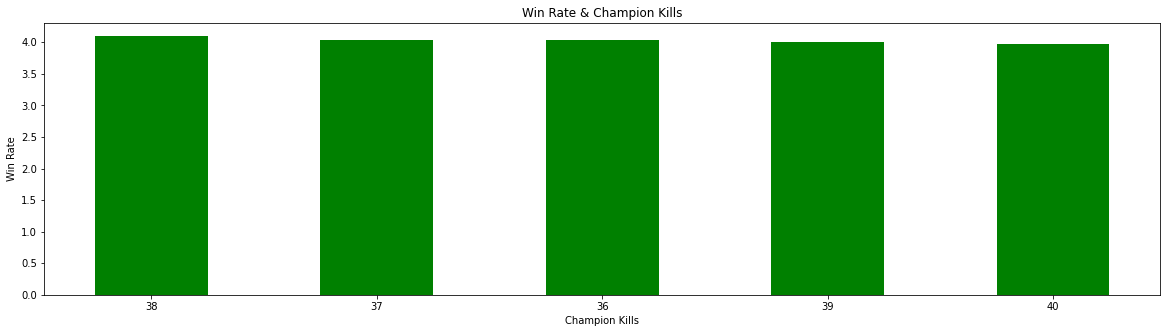

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(ChampionWinRates)
keys = list(data.keys())[:5]
values = list(data.values())[:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Win Rate')
ax.set_xlabel('Champion Kills')
plt.title("Win Rate & Champion Kills")
plt.show()
plt.savefig(savePath+'Win Rate & Champion Kills.png')

##Champion Kills&Champion

In [ ]:
#MetaData Order['champion','baron','dragon','riftHerald','tower']

#["Champ1Team1","Champ2Team1","Champ3Team1","Champ4Team1","Champ5Team1","BansTeam1","MetaTeam1",
#"Champ1Team2","Champ2Team2","Champ3Team2","Champ4Team2","Champ5Team2","BansTeam2","MetaTeam2",
#'gameDuration (Mins)','gameVersion']

#we first need to prepare the columns for Rdd Operaions to be done
df_New = df.select([
  #Team that won but every champion carries the meta data and game time
  concat(col("Champ1Team1"), lit(","), col("MetaTeam1"), lit(","), col("gameDuration (Mins)")).alias('Champ1Team1'),
  concat(col("Champ2Team1"), lit(","), col("MetaTeam1"), lit(","), col("gameDuration (Mins)")).alias('Champ2Team1'),
  concat(col("Champ3Team1"), lit(","), col("MetaTeam1"), lit(","), col("gameDuration (Mins)")).alias('Champ3Team1'),
  concat(col("Champ4Team1"), lit(","), col("MetaTeam1"), lit(","), col("gameDuration (Mins)")).alias('Champ4Team1'),
  concat(col("Champ5Team1"), lit(","), col("MetaTeam1"), lit(","), col("gameDuration (Mins)")).alias('Champ5Team1'),
  #Team that lost but every champion carries the meta data and game time
  concat(col("Champ1Team2"), lit(","), col("MetaTeam2"), lit(","), col("gameDuration (Mins)")).alias('Champ1Team2'),
  concat(col("Champ2Team2"), lit(","), col("MetaTeam2"), lit(","), col("gameDuration (Mins)")).alias('Champ2Team2'),
  concat(col("Champ3Team2"), lit(","), col("MetaTeam2"), lit(","), col("gameDuration (Mins)")).alias('Champ3Team2'),
  concat(col("Champ4Team2"), lit(","), col("MetaTeam2"), lit(","), col("gameDuration (Mins)")).alias('Champ4Team2'),
  concat(col("Champ5Team2"), lit(","), col("MetaTeam2"), lit(","), col("gameDuration (Mins)")).alias('Champ5Team2'),
])

In [ ]:
df_New.show(1)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|         Champ1Team2|         Champ2Team2|         Champ3Team2|         Champ4Team2|         Champ5Team2|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|48,3074,6632,3047...|82,666,531,164,63...|246,669,631,563,1...|67,3124,6672,3006...|63,385,366,533,02...|41,2033,3508,3047...|56,6696,3156,6691...|90,665,331,164,63...|81,3074,3158,3078...|29,311,538,533,00...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----

In [ ]:
#One champion cell carries this information
#       0         1        2        3        4        5        6        7         8       9         10         11             12
#['championId','item0', 'item1', 'item2', 'item3', 'item4', 'item5','champion','baron','dragon','riftHerald','tower','gameDuration (Mins)']

In [ ]:
Champion_TeamKills = df_New.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[0],(int(champ.split(',')[7]),1))) \
          .reduceByKey(lambda c1,c2:(c1[0]+c2[0],c1[1]+c2[1])) \
          .map(lambda champ:(champ[0],round((champ[1][0]/champ[1][1]),2)))\
          .sortBy(lambda game: game[1],ascending=False)\
          .map(lambda champ:(Id_to_ChampName.get(champ[0]),champ[1])) \
          .collect()

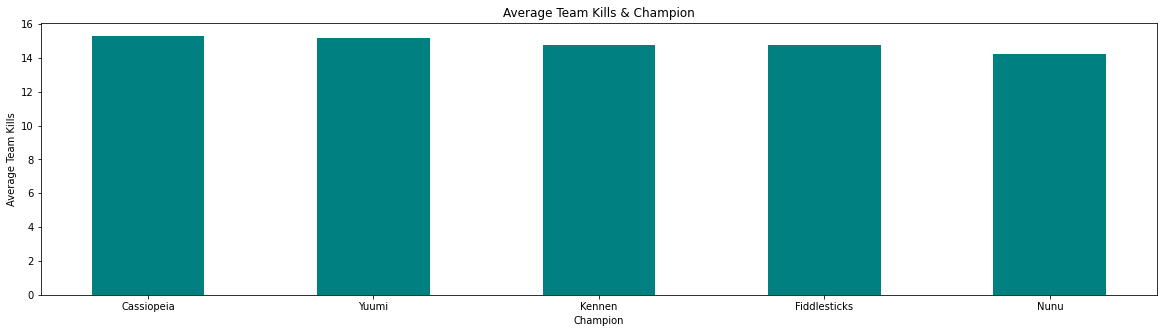

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(Champion_TeamKills)
keys = list(data.keys())[:5]
values = list(data.values())[:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['teal'],width = 0.5)
ax.set_ylabel('Average Team Kills')
ax.set_xlabel('Champion')
plt.title("Average Team Kills & Champion")
plt.show()
plt.savefig(savePath+'Average Team Kills & Champion.png')

##Tower Kills&Champion

In [ ]:
Champion_TowerKills = df_New.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[0],(int(champ.split(',')[11]),1))) \
          .reduceByKey(lambda c1,c2:(c1[0]+c2[0],c1[1]+c2[1])) \
          .map(lambda champ:(champ[0],round((champ[1][0]/champ[1][1]),2)))\
          .sortBy(lambda champ: champ[1],ascending=False)\
          .map(lambda champ:(Id_to_ChampName.get(champ[0]),champ[1])) \
          .collect()

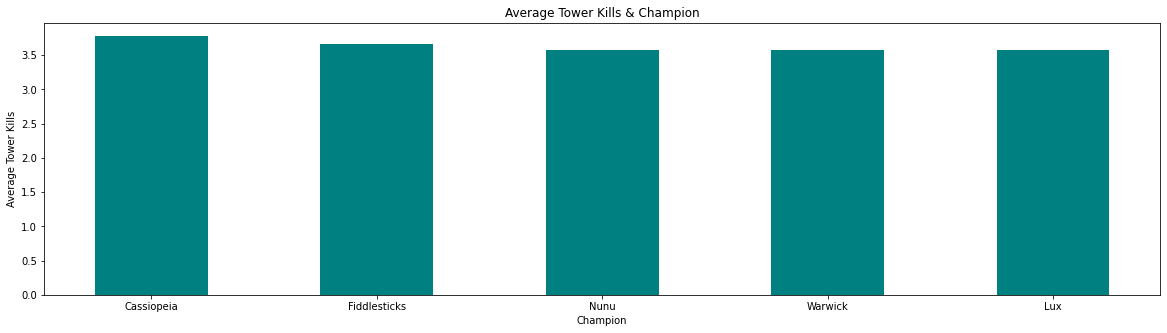

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(Champion_TowerKills)
keys = list(data.keys())[:5]
values = list(data.values())[:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['teal'],width = 0.5)
ax.set_ylabel('Average Tower Kills')
ax.set_xlabel('Champion')
plt.title("Average Tower Kills & Champion")
plt.show()
plt.savefig(savePath+'Average Tower Kills & Champion.png')

##Game Time&Champion

In [ ]:
Champion_GameTime = df_New.rdd.flatMap(lambda x:x)\
          .map(lambda champ:(champ.split(',')[0],(float(champ.split(',')[12]),1))) \
          .reduceByKey(lambda c1,c2:(c1[0]+c2[0],c1[1]+c2[1])) \
          .map(lambda champ:(champ[0],round((champ[1][0]/champ[1][1]),2)))\
          .sortBy(lambda champ: champ[1],ascending=False)\
          .map(lambda champ:(Id_to_ChampName.get(champ[0]),champ[1])) \
          .collect()

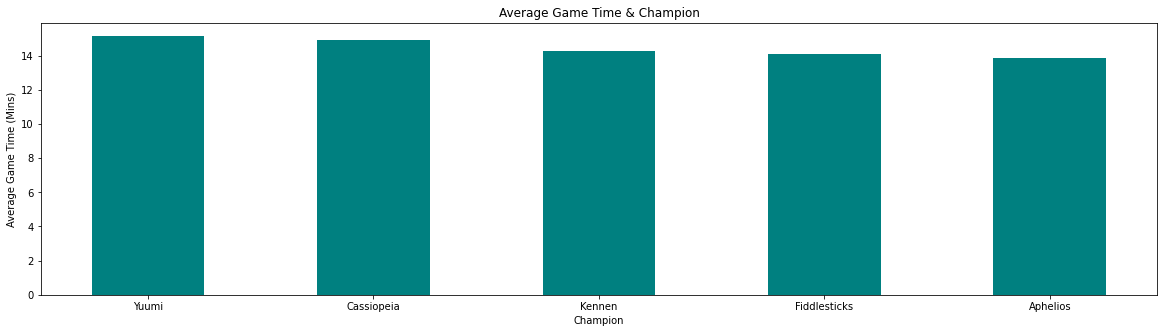

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(Champion_GameTime)
keys = list(data.keys())[:5]
values = list(data.values())[:5]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['teal'],width = 0.5)
ax.set_ylabel('Average Game Time (Mins)')
ax.set_xlabel('Champion')
plt.title("Average Game Time & Champion")
plt.show()
plt.savefig(savePath+'Average Game Time & Champion.png')

# Machine Learning

## Remove irrelevant columns

In [ ]:
df_selected = Maindf.select(['Champ1Team1', 'Champ2Team1', 'Champ3Team1', 'Champ4Team1', 'Champ5Team1',
                         'Champ1Team2', 'Champ2Team2', 'Champ3Team2', 'Champ4Team2', 'Champ5Team2', 'gameDuration (Mins)'])

In [ ]:
df_selected.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|         Champ1Team2|         Champ2Team2|         Champ3Team2|         Champ4Team2|         Champ5Team2|gameDuration (Mins)|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|48,3074,6632,3047...|82,666,531,164,63...|246,669,631,563,1...|67,3124,6672,3006...|63,385,366,533,02...|41,2033,3508,3047...|56,6696,3156,6691...|90,665,331,164,63...|81,3074,3158,3078...|29,311,538,533,00...|              35.55|
|82,105,446,333,15...|131,315,231,573,0...|777,300,666,733,0...|236,667,

## Modifying our data

In [ ]:
Part1, Part2 = df_selected.randomSplit([.5, .5])
Part1.count()

47824

In [ ]:
Part1 = Part1.withColumn("Winner", lit(1))

In [ ]:
Part2.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|         Champ1Team2|         Champ2Team2|         Champ3Team2|         Champ4Team2|         Champ5Team2|gameDuration (Mins)|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|1,105,666,553,135...|254,663,220,316,3...|42,304,230,746,65...|81,3074,6694,3078...|350,322,238,531,0...|107,314,266,913,0...|114,1037,3111,663...|101,102,631,574,6...|360,303,530,721,0...|22,4005,3042,3158...|              35.67|
|1,105,866,553,020...|120,304,231,333,1...|246,669,110,363,0...|429,309,

In [ ]:
for i in range(1,6):
  Part2 = Part2.withColumnRenamed("Champ{}Team1".format(i),"Temp")
  Part2 = Part2.withColumnRenamed("Champ{}Team2".format(i),"Champ{}Team1".format(i))
  Part2 = Part2.withColumnRenamed("Temp","Champ{}Team2".format(i))
Part2 = Part2.withColumn("Winner", lit(0))

In [ ]:
Part2.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------+
|         Champ1Team2|         Champ2Team2|         Champ3Team2|         Champ4Team2|         Champ5Team2|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|gameDuration (Mins)|Winner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------+
|1,105,666,553,135...|254,663,220,316,3...|42,304,230,746,65...|81,3074,6694,3078...|350,322,238,531,0...|107,314,266,913,0...|114,1037,3111,663...|101,102,631,574,6...|360,303,530,721,0...|22,4005,3042,3158...|              35.67|     0|
|1,105,866,553,020...|120,304,231,333,1...|2

In [ ]:
result1 = Part1.unionByName(Part2)

# display
result1.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------+
|         Champ1Team1|         Champ2Team1|         Champ3Team1|         Champ4Team1|         Champ5Team1|         Champ1Team2|         Champ2Team2|         Champ3Team2|         Champ4Team2|         Champ5Team2|gameDuration (Mins)|Winner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------+
|1,0,3152,3089,302...|120,304,231,613,1...|29,300,646,443,15...|51,6671,3031,0,30...|89,385,731,093,00...|48,308,230,743,19...|11,303,135,081,00...|13,304,031,573,08...|221,3036,0,6673,3...|555,385,720,553,1...|              32.25|     1|
|1,102,631,523,157...|59,633,366,923,04...|1

In [ ]:
df1 = result1
for k in range(1,3):
  for i in range(1,6):
    df1 = df1.withColumn('Champion{}_Team{}'.format(i,k), split(df_selected['Champ{}Team{}'.format(i,k)], ',').getItem(0))
    df1 = df1.withColumn('Champion{}_Team{}'.format(i,k), df1['Champion{}_Team{}'.format(i,k)].cast(IntegerType()))
    for j in range(1,7):
      df1 = df1.withColumn('Champion{}_Item{}_Team{}'.format(i,j,k), split(df_selected['Champ{}Team{}'.format(i,k)], ',').getItem(j))
      df1 = df1.withColumn('Champion{}_Item{}_Team{}'.format(i,j,k), df1['Champion{}_Item{}_Team{}'.format(i,j,k)].cast(IntegerType()))
    df1 = df1.drop("Champ{}Team{}".format(i,k))

df1.show(5, truncate=False)

+-------------------+------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+--

In [ ]:
df1.printSchema()

root
 |-- gameDuration (Mins): double (nullable = true)
 |-- Winner: integer (nullable = false)
 |-- Champion1_Team1: integer (nullable = true)
 |-- Champion1_Item1_Team1: integer (nullable = true)
 |-- Champion1_Item2_Team1: integer (nullable = true)
 |-- Champion1_Item3_Team1: integer (nullable = true)
 |-- Champion1_Item4_Team1: integer (nullable = true)
 |-- Champion1_Item5_Team1: integer (nullable = true)
 |-- Champion1_Item6_Team1: integer (nullable = true)
 |-- Champion2_Team1: integer (nullable = true)
 |-- Champion2_Item1_Team1: integer (nullable = true)
 |-- Champion2_Item2_Team1: integer (nullable = true)
 |-- Champion2_Item3_Team1: integer (nullable = true)
 |-- Champion2_Item4_Team1: integer (nullable = true)
 |-- Champion2_Item5_Team1: integer (nullable = true)
 |-- Champion2_Item6_Team1: integer (nullable = true)
 |-- Champion3_Team1: integer (nullable = true)
 |-- Champion3_Item1_Team1: integer (nullable = true)
 |-- Champion3_Item2_Team1: integer (nullable = true)
 |--

In [ ]:
df1.select("Champion1_Team2").show()

+---------------+
|Champion1_Team2|
+---------------+
|             48|
|             39|
|            107|
|            777|
|             12|
|             67|
|            516|
|             82|
|            223|
|             17|
|             41|
|             24|
|             30|
|            777|
|            420|
|            157|
|            164|
|            777|
|            240|
|            145|
+---------------+
only showing top 20 rows



## Data Preparation

In [ ]:
List = df1.columns[2:-1]
List.append(df1.columns[0])

In [ ]:
List[:10]

['Champion1_Team1',
 'Champion1_Item1_Team1',
 'Champion1_Item2_Team1',
 'Champion1_Item3_Team1',
 'Champion1_Item4_Team1',
 'Champion1_Item5_Team1',
 'Champion1_Item6_Team1',
 'Champion2_Team1',
 'Champion2_Item1_Team1',
 'Champion2_Item2_Team1']

In [ ]:
'''
OHE = OneHotEncoder(inputCols=['Champion1_Team1', 'Champion2_Team1', 'Champion3_Team1', 'Champion4_Team1',
                          'Champion5_Team1', 'Champion1_Team2', 'Champion2_Team2', 'Champion3_Team2', 'Champion4_Team2',
                          'Champion5_Team2'],outputCols=['Champion1_Team1_Encoded', 'Champion2_Team1_Encoded', 'Champion3_Team1_Encoded',
                                                         'Champion4_Team1_Encoded','Champion5_Team1_Encoded', 'Champion1_Team2_Encoded',
                                                         'Champion2_Team2_Encoded', 'Champion3_Team2_Encoded', 'Champion4_Team2_Encoded', 'Champion5_Team2_Encoded'])
vec_assembler = VectorAssembler(inputCols=['Champion1_Team1_Encoded', 'Champion2_Team1_Encoded', 'Champion3_Team1_Encoded',
                                                         'Champion4_Team1_Encoded','Champion5_Team1_Encoded', 'Champion1_Team2_Encoded',
                                                         'Champion2_Team2_Encoded', 'Champion3_Team2_Encoded', 'Champion4_Team2_Encoded',
                                            'Champion5_Team2_Encoded'], outputCol="features")
'''

'\nOHE = OneHotEncoder(inputCols=[\'Champion1_Team1\', \'Champion2_Team1\', \'Champion3_Team1\', \'Champion4_Team1\',\n                          \'Champion5_Team1\', \'Champion1_Team2\', \'Champion2_Team2\', \'Champion3_Team2\', \'Champion4_Team2\',\n                          \'Champion5_Team2\'],outputCols=[\'Champion1_Team1_Encoded\', \'Champion2_Team1_Encoded\', \'Champion3_Team1_Encoded\',\n                                                         \'Champion4_Team1_Encoded\',\'Champion5_Team1_Encoded\', \'Champion1_Team2_Encoded\',\n                                                         \'Champion2_Team2_Encoded\', \'Champion3_Team2_Encoded\', \'Champion4_Team2_Encoded\', \'Champion5_Team2_Encoded\'])\nvec_assembler = VectorAssembler(inputCols=[\'Champion1_Team1_Encoded\', \'Champion2_Team1_Encoded\', \'Champion3_Team1_Encoded\',\n                                                         \'Champion4_Team1_Encoded\',\'Champion5_Team1_Encoded\', \'Champion1_Team2_Encoded\',\n        

In [ ]:
vec_assembler = VectorAssembler(inputCols=List, outputCol="features")

In [ ]:
# Make the pipeline
final_pipe = Pipeline(stages=[vec_assembler])

In [ ]:
piped_data = final_pipe.fit(df1).transform(df1)

In [ ]:
piped_data.show(5)

+-------------------+------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------+---------------------+---------------------+---------------------+--

In [ ]:
piped_dataset = piped_data.withColumnRenamed("Winner", "label")

In [ ]:
model_data = piped_dataset.select(['label','features'])

In [ ]:
model_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[1.0,0.0,3152.0,3...|
|    1|[1.0,102.0,631.0,...|
|    1|[1.0,105.0,666.0,...|
|    1|[1.0,1056.0,6653....|
|    1|[1.0,1056.0,6653....|
+-----+--------------------+
only showing top 5 rows



## Models

### Model Building (Logistic Regression)

In [ ]:
training, test = model_data.randomSplit([.7, .3])
training.count()

67048

In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol='label')
model = lr.fit(training)

### Model Evaluation

In [ ]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()

In [ ]:
roc

,FPR,TPR
0,0.000000,0.000000
1,0.000149,0.001849
2,0.000597,0.003400
3,0.001014,0.004981
4,0.001313,0.006681
...,...,...
998,0.994690,0.999433
999,0.996509,0.999612
1000,0.998210,0.999911
1001,1.000000,1.000000


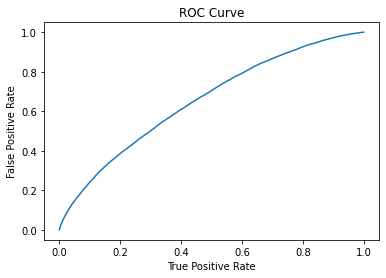

In [ ]:

plt.clf()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [ ]:
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Training set areaUnderROC: 0.6534858740421683


Text(0.5, 0, 'Recall')

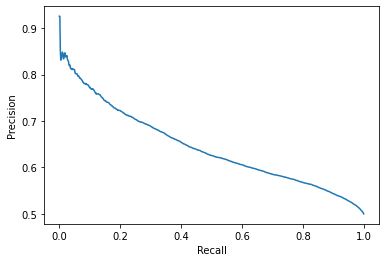

In [ ]:
plt.clf()
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
summary = model.evaluate(test)

In [ ]:
summary.accuracy

0.6053567691985771

In [ ]:
output = model.transform(test)
output

DataFrame[label: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
output.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|(70,[0,1,2,3,4,5,...|[0.15053102334363...|[0.53756185459256...|       0.0|
|    1|(70,[0,1,2,3,4,5,...|[-0.5688867124242...|[0.36149374981334...|       1.0|
|    1|(70,[0,1,2,3,4,7,...|[0.11752828911927...|[0.52934829796539...|       0.0|
|    1|(70,[0,1,2,3,4,7,...|[-0.0972245296087...|[0.47571299588094...|       1.0|
|    1|(70,[0,1,2,3,4,7,...|[0.41973531283215...|[0.60341991081567...|       0.0|
|    1|(70,[0,1,2,3,4,7,...|[-1.1172097770833...|[0.24652920796117...|       1.0|
|    1|(70,[0,1,2,3,4,7,...|[0.14235661180685...|[0.53552917211940...|       0.0|
|    1|(70,[0,1,2,3,4,7,...|[-0.7403664788734...|[0.32292401012094...|       1.0|
|    1|(70,[0,1,2,3,6,7,...|[-0.1142194879596...|[0.47147613168560...|       1.0|
|    1|(70,[0,1,

In [ ]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(output))

Test Area Under ROC 0.6567529202962027


### Model Building (Gradient-Boosted Tree Classifier)

In [ ]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

In [ ]:
model = gbt.fit(training)

In [ ]:
prediction = model.transform(test)

binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")

binEval.evaluate(prediction)

0.6229685429308781

### Model Building (Random Forest)

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50)

model = rf.fit(training)

In [ ]:
prediction = model.transform(test)

binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")

binEval.evaluate(prediction)

0.6054962683964568

### Model Building (Support Vector Machines)

In [ ]:
SVC = LinearSVC(labelCol="label", featuresCol="features", maxIter=10, regParam=0.1)

model = SVC.fit(training)

In [ ]:
prediction = model.transform(test)

binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")

binEval.evaluate(prediction)

0.6030201576340936

In [ ]:
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: [-7.613117049512444e-05,-5.940232747642775e-05,-4.2864211838444296e-05,-3.6700063953831445e-05,1.801312864057599e-05,5.8745542848702825e-05,3.184448451446779e-05,-2.6402380845927595e-05,-4.742219177968407e-05,-5.537929545169908e-05,-4.485788385663901e-05,2.2628636547118503e-05,5.58322704217395e-05,4.360644515912757e-05,6.332710016071887e-05,-6.232935278320302e-05,-5.9040806940170056e-05,-3.223934365346064e-05,6.5647613277515616e-06,4.982240298664503e-05,4.607478536894399e-05,0.000142630726318034,-4.8943142014807726e-05,-5.6473870817278346e-05,-3.906836161763224e-05,1.5242313176348912e-05,5.6902389073680796e-05,3.823763098619266e-05,2.5885142632878456e-05,-6.405182899185887e-05,-5.342255498236004e-05,-4.7226390633618136e-05,1.93242610087762e-05,7.203477920553252e-05,0.0001117892853937175,9.130224160817187e-05,4.9129435000646835e-05,4.615692215061208e-05,4.5523820595681206e-05,-2.439123448486552e-05,-7.490809824385021e-05,-3.5668532284768506e-05,-1.6171189411107677e-05,4.67

### Model Building (One vs All)

In [ ]:
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

ovr = OneVsRest(classifier=lr)

model = ovr.fit(training)

In [ ]:
prediction = model.transform(test)

binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")

binEval.evaluate(prediction)

0.6053218943991072

### Model Building (Naive Bayes)

In [ ]:
NB = NaiveBayes(smoothing=1.0, modelType="multinomial")

NBmodel = ovr.fit(training)

In [ ]:
prediction = NBmodel.transform(test)

binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")

binEval.evaluate(prediction)

0.6053218943991072

### Model Building (FM Classifier)

In [ ]:
FM = FMClassifier(labelCol="label", featuresCol="features", stepSize=0.001)

FMmodel = FM.fit(training)

In [ ]:
prediction = FMmodel.transform(test)

binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")

binEval.evaluate(prediction)

0.5385715282137128

## Clustering

### Kmeans

In [ ]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(model_data)

In [ ]:
predictions = model.transform(model_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.13130204902244133
Cluster Centers: 
[ 170.62443594 1876.7298751  2216.87473811 1941.31259065 1552.69252619
  964.73571716  253.86474617  125.44216358 2676.24419823 2430.77078969
 2237.64462127 1848.36105963 1089.16257051  363.2075141   179.93031829
 2068.18714746 2362.54454069 2055.08086221 1617.90932716 1016.80231668
  321.55122885  145.5935133  2350.96887591 2710.92816277 2249.48748993
 1757.44256648 1021.19544722  295.96512893  175.14603143 2303.65662772
 2267.6707494  2040.07350927 1759.77135375 1151.9107776   431.42097099
  169.69788477 1891.64010878 2218.69929492 1953.78152699 1549.72993554
  962.03470991  254.68321918  125.62407333 2670.48982675 2408.13231265
 2247.71003223 1858.30394843 1096.35680902  364.80898469  180.15348509
 2086.05433118 2347.99206285 2057.79580983 1623.64768332 1025.10181305
  319.97473811  146.70225624 2336.42731668 2703.19101531 2260.63638195
 1736.1762087  1021.54071313  319.20134972  177.12369057 2329.666

In [ ]:
ks = [3,7,10]
silhouette_score = []

for k_num in ks:
    # build kmeans model with k as no of cluster
    print("K :  ",k_num)
    model_k = KMeans(k=k_num , seed=1)

    # train the model
    model = model_k.fit(model_data.select('features'))
    final_output  = model.transform(model_data)
    # Append costfunction to list of costfunction
    silhouette_score.append(evaluator.evaluate(final_output))

K :   3
K :   7
K :   10


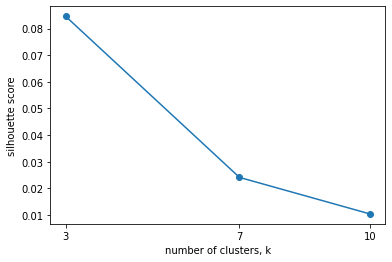

In [ ]:
# Plot k vs cost_function
plt.plot(ks, silhouette_score, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

### LDA

In [ ]:
lda = LDA(k=10, maxIter=10)
model = lda.fit(model_data)

ll = model.logLikelihood(model_data)
lp = model.logPerplexity(model_data)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))

# Describe topics.
topics = model.describeTopics(3)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

# Shows the result
transformed = model.transform(model_data)
transformed.show(5, truncate=False)

The lower bound on the log likelihood of the entire corpus: -27908701961.539814
The upper bound on perplexity: 3.807441487629812
The topics described by their top-weighted terms:
+-----+------------+----------------------------------------------------------------+
|topic|termIndices |termWeights                                                     |
+-----+------------+----------------------------------------------------------------+
|0    |[43, 46, 45]|[0.05604716616230475, 0.050898631002676026, 0.0500503536243828] |
|1    |[8, 9, 65]  |[0.06102567993757003, 0.04147091514695986, 0.040359996488833975]|
|2    |[58, 60, 57]|[0.09977622021482445, 0.09654324397252544, 0.094427876728685]   |
|3    |[36, 37, 38]|[0.06893009864339847, 0.05942065473430955, 0.05007665783493573] |
|4    |[15, 16, 17]|[0.09098543795044776, 0.08111123381999007, 0.07730713304547875] |
|5    |[2, 3, 4]   |[0.09676394134378791, 0.08621554788277032, 0.08581072608684653] |
|6    |[23, 22, 51]|[0.06594995361230513, 0.049

### Gaussian Mixture

In [ ]:
gmm = GaussianMixture().setK(2).setSeed(538009335)
model = gmm.fit(model_data)

print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show(5, truncate=False)

Gaussians shown as a DataFrame: 
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Clustering Items

In [ ]:
List_Items = []
for element in List:
  if "Item" in element:
    List_Items.append(element)

In [ ]:
df_Items = df1.select(List_Items)

In [ ]:
df_Items.show(5)

+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------

In [ ]:
vec_assembler_Cluster = VectorAssembler(inputCols=List_Items, outputCol="features")

In [ ]:
final_pipe_Cluster = Pipeline(stages=[vec_assembler_Cluster])

In [ ]:
piped_data_Cluster = final_pipe_Cluster.fit(df_Items).transform(df_Items)

In [ ]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(piped_data_Cluster)

In [ ]:
predictions = model.transform(piped_data_Cluster)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.13156102752406915
Cluster Centers: 
[1876.65849482 2216.80709883 1941.24596108 1552.6320253   964.7109504
  253.85451835 2676.21123242 2430.80973772 2237.63837073 1848.35876878
 1089.20734459  363.19288103 2068.12356472 2362.47911043 2055.01547077
 1617.84783047 1016.77686233  321.53827404 2351.02207808 2710.95799927
 2249.46353894 1757.39238951 1021.16034809  295.95320495 2303.64918819
 2267.64356795 2040.00429072 1759.77281334 1151.99842875  431.46442529
 1891.70367834 2218.64789896 1953.72636074 1549.69521776  962.06337376
  254.67295838 2670.39563273 2408.05739092 2247.64987309 1858.24324161
 1096.31263849  364.7942871  2085.99764312 2348.03217034 2057.81797671
 1623.64606583 1025.12300068  319.96184682 2336.46970307 2703.15406309
 2260.60863785 1736.16826478 1021.56665727  319.18848959 2329.65841425
 2306.93702913 2077.58492809 1786.28655171 1154.84122316]
[1146.40351562 1239.63550347 1135.06857639  855.80987413  636.72979601
  149.56

In [ ]:
ks = [3,7,10]
silhouette_score = []

for k_num in ks:
    # build kmeans model with k as no of cluster
    print("K :  ",k_num)
    model_k = KMeans(k=k_num , seed=1)

    # train the model
    model = model_k.fit(piped_data_Cluster.select('features'))
    final_output  = model.transform(piped_data_Cluster)
    # Append costfunction to list of costfunction
    silhouette_score.append(evaluator.evaluate(final_output))

K :   3
K :   7
K :   10


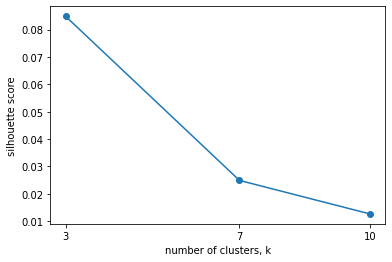

In [ ]:
# Plot k vs cost_function
plt.plot(ks, silhouette_score, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()